In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
%matplotlib inline
from sklearn.model_selection import train_test_split


from collections import Counter
import spacy
from tqdm.auto import tqdm
tqdm.pandas(desc='Progress')

## Helper functions

In [31]:
def indices_func(sentence):
    indices = [2]
    for word in nlp(cleanString(sentence)):
        try:
            indices.append(word_index[word.text.lower()])
        except:
            indices.append(1)
            
    indices.append(3)
    return indices

def cleanString(s):
    s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def replace(x):
    if (x==4): 
        return 1 
    else: 
        return x

nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])

## Process data and save to file

In [6]:
data = pd.read_csv("data/large/train.csv",encoding = "ISO-8859-1",names=["target","id","date","flag","user","text"])
data['text'] = data.text.progress_apply(lambda x: x.strip())
data_vals = data.values


sentences = data_vals[:,5]

words = Counter()
for sentence in tqdm(sentences):
    try:
        words.update(word.text.lower() for word in nlp(cleanString(sentence)))
    except:
        break
        
words = sorted(words, key=words.get, reverse=True)
words = ['PAD','CTX','SOS','EOS'] + words

word_df = pd.DataFrame(words)
word_df = word_df[:20000] #Limit to 20k most common words
word_df.to_csv("data/words.csv")

## Read data from csv and tokenize

In [3]:
word_df = pd.read_csv("data/words.csv",squeeze=True)
index_word = {x:y for x,y in enumerate(word_df["0"])}
word_index = {y:x for x,y in enumerate(word_df["0"])}

## Convert test/train data

In [8]:
data['indices'] = data.text.progress_apply(indices_func)
data['length'] = data.indices.progress_apply(len)
data['target'] = data.target.progress_apply(replace)

## Convert slack data

In [37]:
slack_messages = pd.read_csv("data/slack/all_slack.csv",encoding = "ISO-8859-1", header=None)
slack_messages[0] = slack_messages[0].progress_apply(cleanString)
slack_messages['indices'] = slack_messages[0].progress_apply(indices_func)
slack_messages['length'] = slack_messages.indices.progress_apply(len)

slack_messages.to_csv("data/large/slack_test.csv")

## Show data distribution

Max data length 120
Distribution:


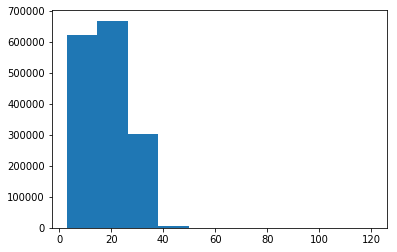

In [35]:
print("Max data length",data.length.values.max())
print("Distribution:")
plt.hist(data.length.values)
plt.show();


## Slack data distribution

Max data length 226
Distribution:


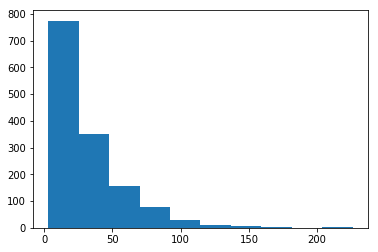

In [36]:
print("Max data length",slack_messages.length.values.max())
print("Distribution:")
plt.hist(slack_messages.length.values)
plt.show();

## Save word index and processed data into a file

In [36]:
dfind = pd.DataFrame.from_dict(index_word,orient="index")

In [37]:
dfind.to_csv("data/word_index.csv")
data.to_csv("data/large/processed.csv")

## Split data into train and test

In [11]:
processed = pd.read_csv("data/large/processed.csv",squeeze=True)
train, test = train_test_split(processed, test_size=0.2, random_state=1, shuffle=True)

In [14]:
train.to_csv("data/large/processed_train.csv")
test.to_csv("data/large/processed_test.csv")